In [5]:
%matplotlib inline
import psycopg2
from pyiem.network import Table as NetworkTable
import numpy as np
from pandas.io.sql import read_sql

import matplotlib.cm as cm
COOP = psycopg2.connect(database='coop', host='iemdb', user='nobody')

df = read_sql("""
  WITH data as 
  (SELECT station, year, min(extract(doy from day)) as doy from alldata
   WHERE high > 89 GROUP by station, year),
   agg1 as (
   SELECT station, avg(doy), max(year) from data GROUP by station
   )
   
  SELECT agg1.station, agg1.avg, ST_x(geom), ST_Y(geom), agg1.max from stations, agg1
  WHERE agg1.station = stations.id and stations.network ~* 'CLIMATE'
""", COOP, index_col='station')


In [2]:
import datetime

labels = []
ticks = []
tickrange = range(int(df['avg'].min()) - 7, int(df['avg'].max()) + 7, 7)
for i in tickrange:
    ticks.append(i)
    ts = datetime.datetime(2000,1,1) + datetime.timedelta(days=(i-1))
    labels.append( ts.strftime("%-d %b") )

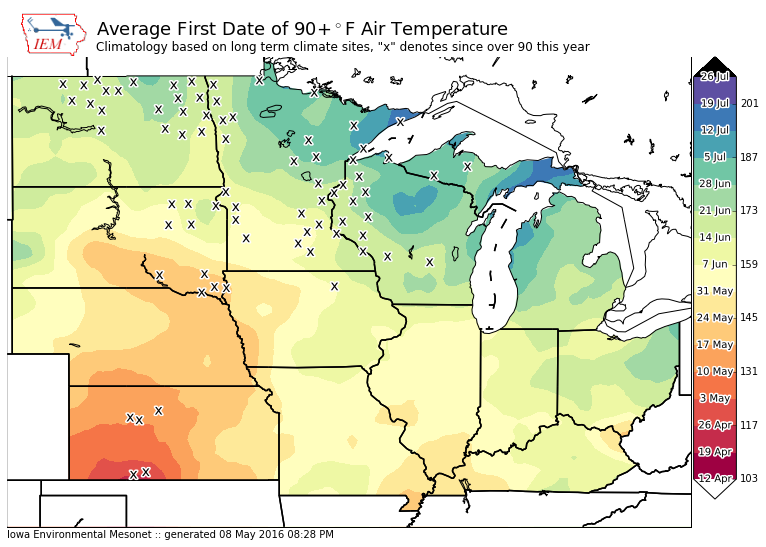

In [8]:
df['x'] = 'x'
df2 = df[df['max'] == 2016]
from pyiem.plot import MapPlot
m = MapPlot(sector='midwest',
            subtitle='Climatology based on long term climate sites, "x" denotes since over 90 this year',
            title='Average First Date of 90+$^\circ$F Air Temperature')
cmap = cm.get_cmap('Spectral')
cmap.set_under('#ffffff')
cmap.set_over('#000000')
m.contourf(df['st_x'], df['st_y'], df['avg'], tickrange, clevlabels=labels, cmap=cmap)
m.plot_values(df2['st_x'], df2['st_y'], df2['x'], '%s', labelbuffer=3)
#m.drawcounties()

m.postprocess(filename='160509.png')